In [137]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/heart-failure-prediction/heart.csv


In [139]:
import plotly.io as pio
pio.renderers.default = 'iframe_connected'

# Background & Objective

Cardiovascular diseases are a leading cause of death worldwide. Early detection of risk factors can help reduce severe outcomes. Machine learning can assist healthcare professionals by predicting patients at risk more effectively.

**Objective:** Build and evaluate models to predict heart disease using clinical and demographic features, supporting early detection and informed decision-making.

# Dataset Overview

- **Source:** Heart Failure Prediction dataset (Kaggle, by FEDESORIANO)  
- **Records:** 918  
- **Features:** 11 clinical/demographic features  
- **Target:** `HeartDisease` (1 = disease, 0 = no disease)  


# Feature Overview

| Feature          | Type        | Description / Note |
|-----------------|------------|------------------|
| Age              | Numeric    | Age of the patient [years] |
| Sex              | Categorical | Male / Female |
| ChestPainType    | Categorical | TA/ATA/NAP/ASY |
| RestingBP        | Numeric    | Resting blood pressure [mm Hg] |
| Cholesterol      | Numeric    | Serum cholesterol [mg/dl] |
| FastingBS        | Binary     | 1 if >120 mg/dl, else 0 |
| RestingECG       | Categorical | ECG result (Normal/ST/LVH) |
| MaxHR            | Numeric    | Maximum heart rate achieved |
| ExerciseAngina   | Binary     | Y/N |
| Oldpeak          | Numeric    | ST depression induced by exercise |
| ST_Slope         | Categorical | Slope of peak exercise ST segment |
| HeartDisease     | Binary     | Target: 1=disease, 0=normal |

# **Import Libraries** 

In [140]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotly.express as px
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")

# **Load Dataset** 

In [141]:
df = pd.read_csv('/kaggle/input/heart-failure-prediction/heart.csv')

In [142]:
df.head()

,Age,Sex,ChestPainType,RestingBP,Cholesterol,FastingBS,RestingECG,MaxHR,ExerciseAngina,Oldpeak,ST_Slope,HeartDisease
0,40,M,ATA,140,289,0,Normal,172,N,0.0,Up,0
1,49,F,NAP,160,180,0,Normal,156,N,1.0,Flat,1
2,37,M,ATA,130,283,0,ST,98,N,0.0,Up,0
3,48,F,ASY,138,214,0,Normal,108,Y,1.5,Flat,1
4,54,M,NAP,150,195,0,Normal,122,N,0.0,Up,0


In [143]:
df.shape

(918, 12)

# **Exploring Data Analysis (EDA)**

### 1. Check Data Types and Non-Null Values

In [144]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 918 entries, 0 to 917
Data columns (total 12 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Age             918 non-null    int64  
 1   Sex             918 non-null    object 
 2   ChestPainType   918 non-null    object 
 3   RestingBP       918 non-null    int64  
 4   Cholesterol     918 non-null    int64  
 5   FastingBS       918 non-null    int64  
 6   RestingECG      918 non-null    object 
 7   MaxHR           918 non-null    int64  
 8   ExerciseAngina  918 non-null    object 
 9   Oldpeak         918 non-null    float64
 10  ST_Slope        918 non-null    object 
 11  HeartDisease    918 non-null    int64  
dtypes: float64(1), int64(6), object(5)
memory usage: 86.2+ KB


The dataset contains 918 rows and 12 columns. 
Numeric features include Age, RestingBP, Cholesterol, MaxHR, Oldpeak. 
Categorical features include Sex, ChestPainType, RestingECG, ExerciseAngina, ST_Slope. 
There are no missing values.

### 2. Summary Statistics

In [145]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
Age,918.0,53.510893,9.432617,28.0,47.00,54.0,60.0,77.0
RestingBP,918.0,132.396514,18.514154,0.0,120.00,130.0,140.0,200.0
Cholesterol,918.0,198.799564,109.384145,0.0,173.25,223.0,267.0,603.0
FastingBS,918.0,0.233115,0.423046,0.0,0.00,0.0,0.0,1.0
MaxHR,918.0,136.809368,25.460334,60.0,120.00,138.0,156.0,202.0
Oldpeak,918.0,0.887364,1.066570,-2.6,0.00,0.6,1.5,6.2
HeartDisease,918.0,0.553377,0.497414,0.0,0.00,1.0,1.0,1.0


- **Invalid Values Detected**  
  - RestingBP = 0  
  - Cholesterol = 0  
  - Oldpeak < 0  
  → Physiologically impossible → likely **missing values or data entry errors**  
  → **Action:** Clean or impute these values  

- **Skewed Distributions**  
  - **RestingBP**: Slightly right-skewed (mean > median), with possible outliers (0 and 200)  
  - **Cholesterol**: Left-skewed (mean < median), with low outliers (0) and high outliers (603)  

- **High Variability**  
  - Cholesterol shows **very high standard deviation (≈109)** compared to its mean, indicating wide spread and potential outliers  

---

**Plan:**  
- Handle invalid values (0 and negative)  
- Consider log/robust scaling for skewed features  
- Tree-based models: scaling not required  
- Linear models: will benefit from normalization  

### 3. Check Missing Values

In [146]:
df.isnull().sum()

Age               0
Sex               0
ChestPainType     0
RestingBP         0
Cholesterol       0
FastingBS         0
RestingECG        0
MaxHR             0
ExerciseAngina    0
Oldpeak           0
ST_Slope          0
HeartDisease      0
dtype: int64

All columns have 918 non-null values. There are no missing values in the dataset.

### 4. Target Class Distribution

In [147]:
df['HeartDisease'].value_counts()

HeartDisease
1    508
0    410
Name: count, dtype: int64

Class 0 = 508, Class 1 = 410 → the dataset is relatively balanced.

### 5. Correlation Heatmap

In [148]:
df_eda = df.select_dtypes(include=np.number)

In [149]:
px.imshow(df_eda.corr(),title='Correlation Plot of the Heat Failure Prediction')

### Feature Correlation with HeartDisease

| Feature      | Correlation | Interpretation / Action                              |
|-------------|------------|-------------------------------------------------------|
| MaxHR       | -0.4       | Lower MaxHR → Higher chance of heart disease; strong predictor |
| Oldpeak     | +0.4       | Higher Oldpeak → Higher chance of heart disease; strong predictor |
| Cholesterol | -0.2       | Weak negative relation; may add value with other features |
| FastingBS   | +0.2       | High blood sugar → Slightly higher chance; supporting feature |
| Age         | +0.2       | Older age → Slightly higher chance; supporting feature |
| RestingBP   | +0.1       | Very weak correlation; may not contribute much individually |

**Summary:**  
- Strongest correlations: **MaxHR** (negative) and **Oldpeak** (positive)  
- Weakly correlated features may still improve model performance when combined

In [150]:
fig = px.histogram(df, x="HeartDisease",
                   color="HeartDisease",
                   text_auto=True,  
                   title="Distribution of HeartDisease",
                   histfunc='count') 
fig.update_layout(bargap=0.4)
fig.show()

### HeartDisease Distribution

- Histogram shows the count of patients with (1) and without (0) heart disease.  
- From the chart, the counts are fairly balanced: 0 = 410, 1 = 508.
- Class imbalance is minimal, so special handling may not be necessary for modeling.  

In [151]:
fig = px.histogram(df,
             x='HeartDisease',
             color='Sex',
             hover_data=df.columns,
             barmode='group',
             title='Distribution of Heart Diseases by Sex')
fig.show()

### HeartDisease Distribution by Sex

- Histogram shows the count of patients with (1) and without (0) heart disease, grouped by sex.  
- Useful to explore whether sex may influence heart disease prevalence.

In [152]:
fig = px.histogram(df, x = "ChestPainType", hover_data = df.columns, title = "Type of Chest pain type")
fig.show()

### Chest Pain Types Distribution

- The histogram shows the distribution of `ChestPainType` across all patients.  
- From the chart, **ASY (Asymptomatic)** is the most common chest pain type.  
- This helps identify which chest pain types are most prevalent in the dataset.

In [153]:
fig = px.histogram(df,
                  x="RestingECG",
                  hover_data=df.columns,
                  title='Distribution of RestingECG')
fig.show()

### Distribution of RestingECG

- Histogram shows the count of different `RestingECG` types across all patients.  
- Helps identify the most common resting ECG patterns in the dataset.

In [154]:
fig = px.histogram(df,
                  x="ST_Slope",
                  hover_data=df.columns,
                  title='Distribution of ST_Slope')
fig.show()

### Distribution of ST_Slope

- Histogram shows the count of different `ST_Slope` types across all patients.  
- Helps identify the most common ST segment slope patterns in the dataset.

## **Outliers**

In [155]:
px.box(df,x='HeartDisease',y='Age',title='Distribution of Age',color='HeartDisease')

### Age Distribution by HeartDisease

- Boxplot shows Age distribution for patients with (1) and without (0) heart disease.  
- Outliers are observed in **HeartDisease = 1**, all on the lower side, indicating unusually young patients that may need attention during preprocessing.

In [156]:
px.box(df,x='HeartDisease',y='Cholesterol',title='Distribution of Cholesterol',color='HeartDisease')

### Cholesterol Distribution by HeartDisease

- Boxplot shows Cholesterol distribution for patients with (1) and without (0) heart disease.  
- Outliers are observed in **HeartDisease = 0**, both low (0) and high values, indicating invalid entries and unusually high cholesterol.  
- Suggest handling during preprocessing (impute, remove, or cap).

In [157]:
px.box(df,x='HeartDisease',y='RestingBP',title='Distribution of RestingBP',color='HeartDisease')

### RestingBP Distribution by HeartDisease

- HeartDisease = 1 → outliers on high side (unusually high blood pressure)  
- HeartDisease = 0 → outliers on both low and high sides (unusually low or high blood pressure)  
- Suggest handling these outliers during preprocessing.

In [158]:
px.box(df,x='HeartDisease',y='MaxHR',title='Distribution of MaxHR',color='HeartDisease')

### MaxHR Distribution by HeartDisease

- HeartDisease = 0 → outliers on the low side (unusually low MaxHR)  
- HeartDisease = 1 → outliers on both low and high sides (unusually low or high MaxHR)  
- Although some patients have extreme MaxHR values, overall negative correlation (MaxHR = -0.4) indicates that lower MaxHR is generally associated with higher chance of heart disease.  
- Suggest handling outliers during preprocessing to improve model learning.

In [159]:
px.box(df,x='HeartDisease',y='Oldpeak',title='Distribution of Oldpeak',color='HeartDisease')

### Oldpeak Distribution by HeartDisease

- **HeartDisease = 0** → Q1 = 0, Median = 0, Q3 = 0.6 → most values = 0, narrow distribution, but many high outliers  
- **HeartDisease = 1** → wider spread, median > 0, with a few high outliers  
- Non-heart disease patients mostly have Oldpeak = 0, but some have extreme high values. Heart disease patients tend to have higher and more variable Oldpeak.  
- **Action**: Consider handling outliers during preprocessing.

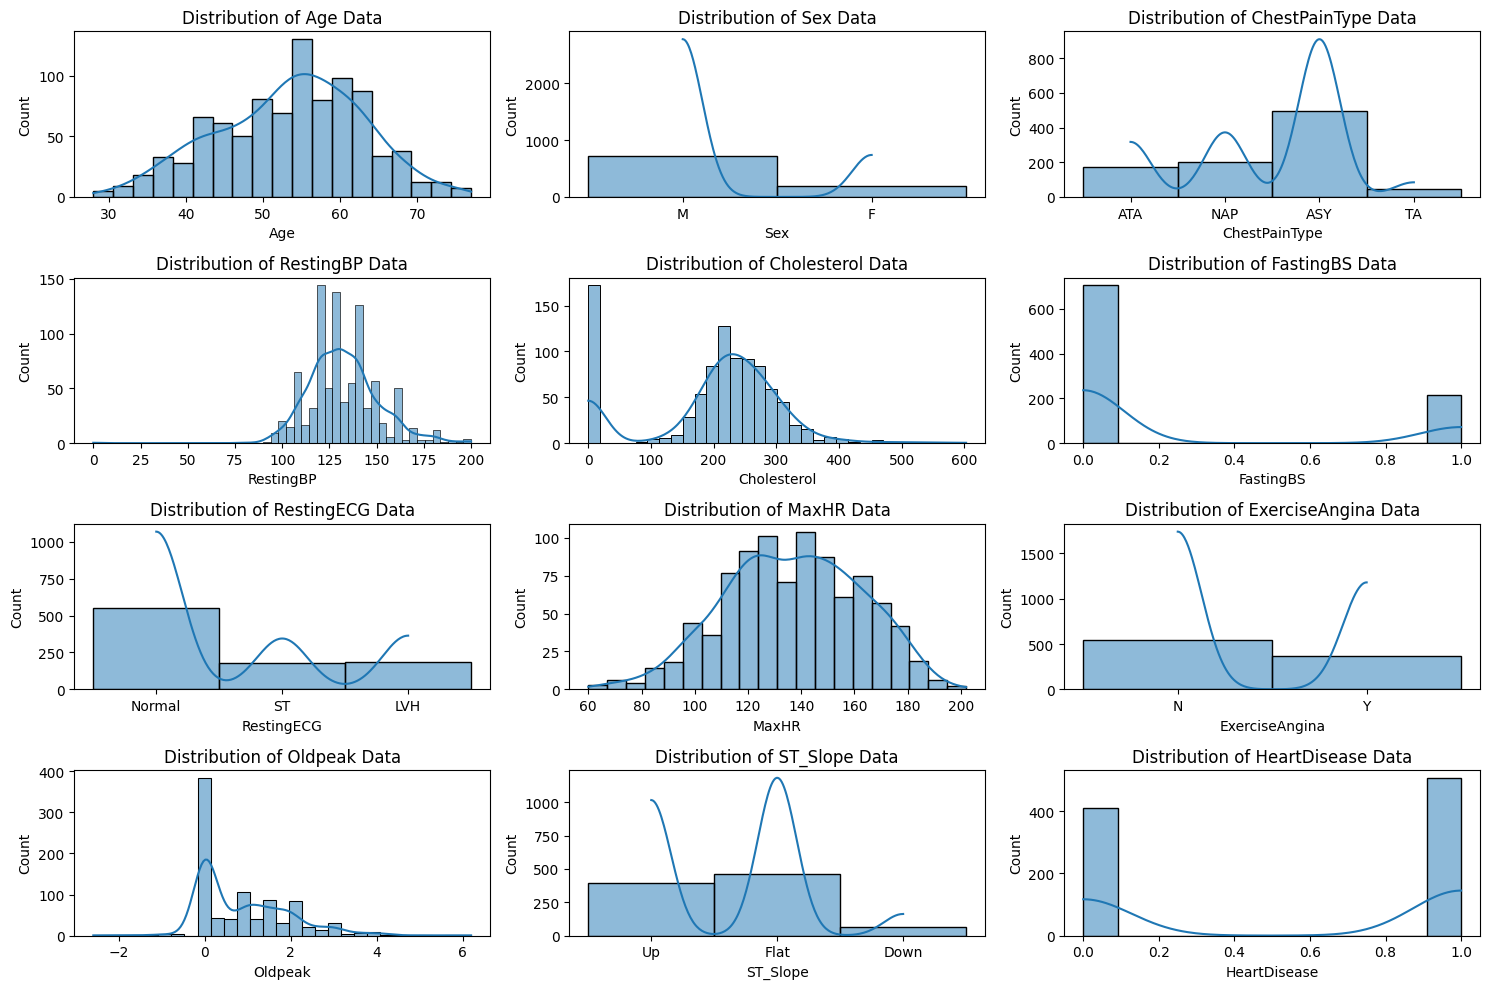

In [160]:
fig = plt.figure(figsize=(15,10))
for i,col in enumerate(df.columns,1):
    plt.subplot(4,3,i)
    plt.title(f"Distribution of {col} Data")
    sns.histplot(df[col],kde=True)

fig.tight_layout()
fig.show()

### Explore distribution & outliers
- **Distribution shape**: Normal, skewed (left/right), uniform, or multimodal  
  *Example: MaxHR ≈ normal, Cholesterol → right-skewed*  
- **Outliers / Invalid values**: Unreasonable values (e.g., RestingBP = 0, Cholesterol = 0) or long tails  
- **Categorical balance**: Check category proportions  
  *Example: Sex → mostly male, ChestPainType → ASY most frequent*  

<Figure size 1500x1000 with 0 Axes>

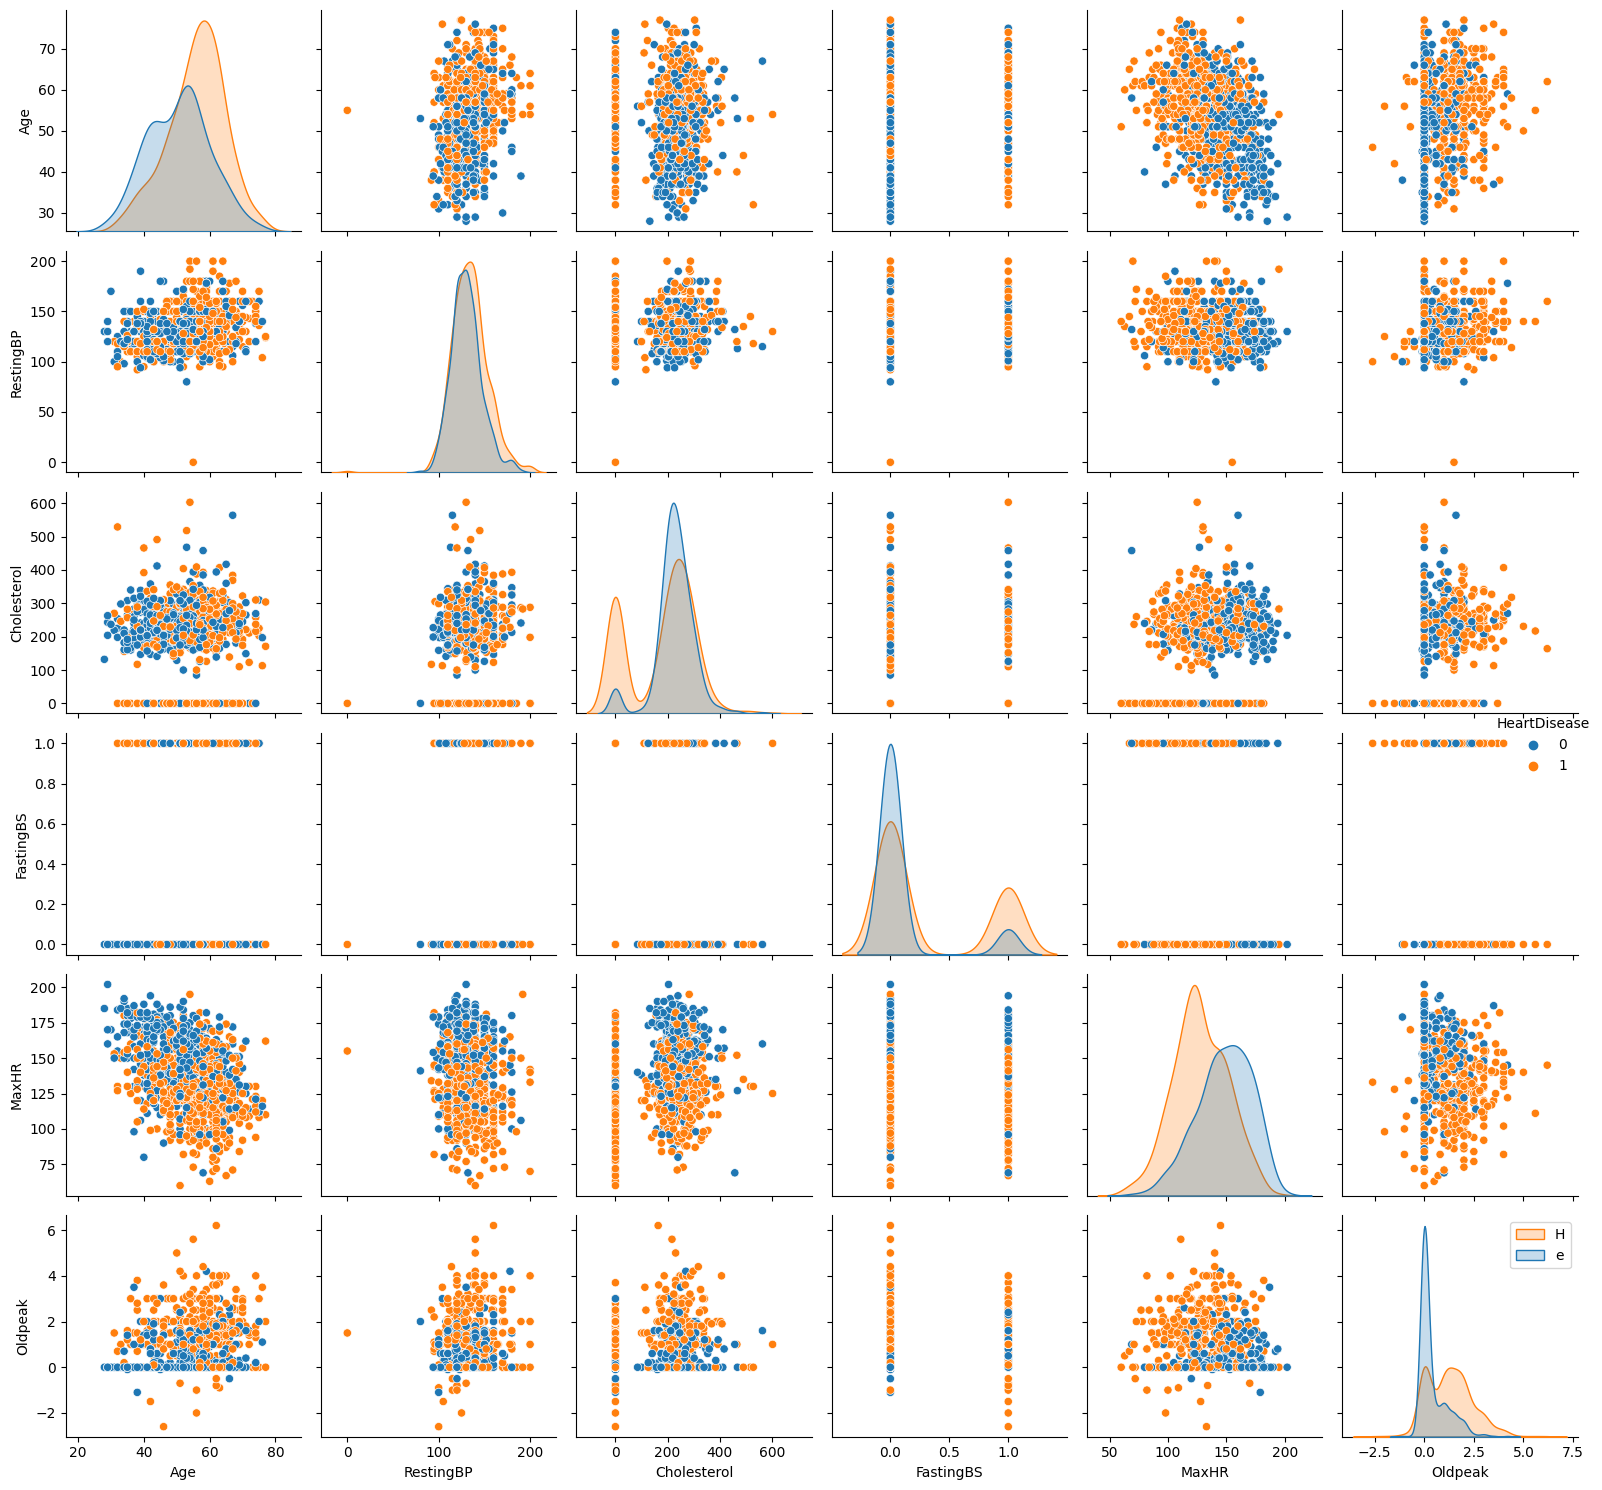

In [161]:
plt.figure(figsize=(15,10))
sns.pairplot(df,hue="HeartDisease")
plt.legend("HeartDisease")
plt.tight_layout()
plt.show()

### Explore relationship with target
- **MaxHR – Most Distinctive Feature**  
  - MaxHR shows clear separation between HeartDisease = 0 and 1 → strong predictor  
  - Patients with lower MaxHR mostly belong to HeartDisease = 1  
- **Other features** (Age, RestingBP, Cholesterol, Oldpeak, etc.) show overlapping distributions → no clear separation  

# **Preprocessing**

## Check Cardinality of Categorical Variables
Categorical features are encoded using one-hot encoding to convert them into numeric format required by machine learning models.  
- The dataset shows that each categorical variable has a small number of categories.  
- Therefore, one-hot encoding will not significantly increase the number of columns and is appropriate for this dataset.

In [162]:
string_col = [col for col in df.columns if df[col].dtype in ['object']]
for col in string_col:
    print(df[col].value_counts())

Sex
M    725
F    193
Name: count, dtype: int64
ChestPainType
ASY    496
NAP    203
ATA    173
TA      46
Name: count, dtype: int64
RestingECG
Normal    552
LVH       188
ST        178
Name: count, dtype: int64
ExerciseAngina
N    547
Y    371
Name: count, dtype: int64
ST_Slope
Flat    460
Up      395
Down     63
Name: count, dtype: int64


## Feature and Target Split
X contains all input features (independent variables).

y contains the target variable HeartDisease (dependent variable).

This separation is necessary to train the machine learning model, where X is used as input and y as the output to be predicted.

In [163]:
X = df.drop('HeartDisease',axis=1)
y = df['HeartDisease']

## Train-Test Split  
- The dataset is split into training (80%) and testing (20%) sets.  
- `stratify=y` ensures that the class distribution (HeartDisease = 0 or 1) remains consistent in both train and test sets.  
- `random_state=42` makes the split reproducible so results can be replicated.  

In [164]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

## Splitting Numeric and Categorical Features 
- numeric_features: stores all columns with numeric data types (int64, float64). These features will later be scaled (e.g., using Robustscaler).

- categorical_features: stores all columns with object data types. These features will later be encoded (e.g., using One-Hot Encoding).

- This separation allows applying different preprocessing techniques depending on the feature type.

In [165]:
numeric_features = [col for col in X_train.columns if X_train[col].dtypes in ['int64', 'float64']]
categorical_features = [col for col in X_train.columns if X_train[col].dtypes in ['object']]

## 🔧 Pipeline for General Models  
We build a preprocessing pipeline to handle both numeric and categorical features, which can be reused across models such as Logistic Regression, KNN, and SVM.  

- **Numeric features:** Missing or zero values are replaced with the median, then scaled using RobustScaler to reduce the effect of outliers.  
- **Categorical features:** Missing values are filled with the most frequent category, then encoded using OneHotEncoder.  
- **ColumnTransformer** applies the appropriate transformations to each feature type, preparing the dataset for various machine learning models.
- **Important:** Fit the pipeline only on the training set to prevent data leakage into the test set.

In [166]:
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OrdinalEncoder, RobustScaler, OneHotEncoder

# Numeric pipeline
numeric_transformer = Pipeline(steps=[
    ("imputer",SimpleImputer(missing_values=0, strategy='median')),
    ("scaler",RobustScaler())
])
# Categorical pipeline
catorical_transformer = Pipeline(steps=[
    ("imputer",SimpleImputer(strategy="most_frequent")),
    ("encoder",OneHotEncoder(handle_unknown= 'ignore'))
])
# ColumnTransformer
preprocessor_lr = ColumnTransformer([
    ('num',numeric_transformer,numeric_features),
    ('cat',catorical_transformer,categorical_features)
])

## 🌳 Pipeline for Tree-Based Models  
We create a preprocessing pipeline for tree-based models such as Decision Trees, Random Forest, and Gradient Boosting.  

- **Numeric features:** Missing or zero values are replaced with the median using `SimpleImputer`. Scaling is not necessary because tree-based models are not sensitive to feature scales.  
- **Categorical features:** Encoded using `OrdinalEncoder`. Missing or unknown categories are handled with a special value (-1) to allow the model to process unseen data.  
- **ColumnTransformer** applies the transformations to numeric and categorical features, preparing the dataset for training tree-based models.
- **Important:** Fit the pipeline only on the training set to prevent data leakage into the test set. 

In [167]:
#preprocessor for tree-based model
preprocessor_treebased = ColumnTransformer([
    ('num', SimpleImputer(missing_values=0, strategy='median'), numeric_features),
    ('cat', OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value= -1), categorical_features)
])

## Cross-Validation Setup

We use **StratifiedKFold (5-fold)** to evaluate model generalization and detect overfitting.

### StratifiedKFold Setup
- `shuffle=True` randomizes data to reduce bias
- Stratified ensures each fold maintains class distribution

In [168]:
from sklearn.model_selection import StratifiedKFold

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

### Cross-Validation Evaluation Function
We define `cross_val_report` to evaluate model performance on each fold using the pipeline.

- The function takes a **pipeline** (`pipe`) and training data (`X_train`, `y_train`)
- For each fold:
  - Train the model on the training portion
  - Predict on the validation portion
  - Print a **classification report** (precision, recall, F1-score)
- The function calculates and prints **average weighted precision, recall, and F1-score** across all folds
- This provides a robust evaluation, especially for imbalanced datasets, compared to a single train/test split

In [169]:
from sklearn.metrics import classification_report

def cross_val_report(pipe,X_train,y_train):
    
    precision_scores = []
    recall_scores = []
    f1_scores = []
    
    for fold, (train_idx, val_idx) in enumerate(cv.split(X_train,y_train),1):
        X_train_fold, X_valid_fold = X_train.iloc[train_idx], X_train.iloc[val_idx]
        y_train_fold, y_valid_fold = y_train.iloc[train_idx], y_train.iloc[val_idx]
        pipe.fit(X_train_fold,y_train_fold)
        y_val_pred = pipe.predict(X_valid_fold)
        print(f"\nClassification report for fold {fold}:")
        print(classification_report(y_valid_fold,y_val_pred))
        report = classification_report(y_valid_fold,y_val_pred, output_dict=True)
        precision_scores.append(report['weighted avg']['precision'])
        recall_scores.append(report['weighted avg']['recall'])
        f1_scores.append(report['weighted avg']['f1-score'])
        
    print("\nAverage precision (weighted):",np.mean(precision_scores))
    print("\nAverage recall (weighted):",np.mean(recall_scores))
    print("\nAverage f1-score (weighted):",np.mean(f1_scores))

# Model Training and Evaluation 

## **Baseline Model (Dummy Classifier)**

We start with a baseline model using **DummyClassifier** with the **stratified strategy**.

- **Purpose:** The baseline serves as a reference point to compare against more complex models (e.g., Logistic Regression, Random Forest, etc.).

- **How it works:** The stratified strategy generates predictions by respecting the training set’s class distribution.  
  Example: If 55% of the training data belongs to class 0 and 45% to class 1, predictions will follow this ratio randomly.

- **Why important:**  
  - Provides a **minimum benchmark** for performance.  
  - Helps to confirm that our final models actually **learn patterns from data** rather than guessing randomly.

In [170]:
from sklearn.dummy import DummyClassifier

pipe_dummy = Pipeline([
    ("preprocess", preprocessor_lr), 
    ("classifier", DummyClassifier(strategy="stratified"))
])

pipe_dummy.fit(X_train, y_train)
y_pred = pipe_dummy.predict(X_test)

In [171]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.42      0.39      0.40        82
           1       0.53      0.56      0.55       102

    accuracy                           0.48       184
   macro avg       0.47      0.47      0.47       184
weighted avg       0.48      0.48      0.48       184



### Baseline Model Performance
- Using DummyClassifier (stratified strategy), we achieved:
  - Accuracy: 0.55
  - Weighted F1-score: 0.55
  - This serves as a **minimum benchmark**. Any real model should perform better than this baseline.

## Model Training and Cross-Validation

We first define the purpose of using pipelines, then evaluate model performance using cross-validation metrics to ensure consistent preprocessing and reliable evaluation.

We implemented models using **Pipelines**, which ensure that preprocessing and model training are applied sequentially and consistently.

---

### Purpose of Using Pipeline
- Ensures data preprocessing is applied the same way to both training and test sets  
- Simplifies workflow and reduces risk of **data leakage**  
- Makes the model modular and easy to maintain

---

### Cross-Validation Metrics
- We used the function `cross_val_report(pipe_lr, X_train, y_train)` to evaluate the model using **Cross-Validation**  
- This calculates metrics (**precision, recall, F1-score**) for each fold of the training data  
- Results allow us to see how the model **generalizes** across different subsets and detect potential **overfitting**  
- Using the **pipeline** ensures preprocessing is consistently applied in each fold, providing reliable metrics


### 1. Logistic Regression
- Pipeline includes general model preprocessing + LogisticRegression classifier
- class_weight='balanced' to handle imbalanced data

In [172]:
# LogisticRegression
from sklearn.linear_model import LogisticRegression

pipe_lr = Pipeline([
    ('preprocess',preprocessor_lr),
    ('classifier',LogisticRegression(class_weight='balanced', random_state=42))
])

# Evaluate with cross-validation
cross_val_report(pipe_lr,X_train,y_train)


Classification report for fold 1:
              precision    recall  f1-score   support

           0       0.80      0.88      0.84        65
           1       0.89      0.83      0.86        82

    accuracy                           0.85       147
   macro avg       0.85      0.85      0.85       147
weighted avg       0.85      0.85      0.85       147


Classification report for fold 2:
              precision    recall  f1-score   support

           0       0.82      0.70      0.75        66
           1       0.78      0.88      0.83        81

    accuracy                           0.80       147
   macro avg       0.80      0.79      0.79       147
weighted avg       0.80      0.80      0.79       147


Classification report for fold 3:
              precision    recall  f1-score   support

           0       0.83      0.86      0.84        66
           1       0.88      0.85      0.87        81

    accuracy                           0.86       147
   macro avg       0.86

### 2. K-Nearest Neighbors (KNN)
- Pipeline includes general preprocessing + KNN classifier
- n_neighbors=5, distance weighting

In [173]:
#knn
from sklearn.neighbors import KNeighborsClassifier

pipe_knn = Pipeline([
    ('preprocess',preprocessor_lr),
    ('classifier',KNeighborsClassifier(n_neighbors=5))
])

# Evaluate with cross-validation
cross_val_report(pipe_knn,X_train,y_train)


Classification report for fold 1:
              precision    recall  f1-score   support

           0       0.81      0.85      0.83        65
           1       0.87      0.84      0.86        82

    accuracy                           0.84       147
   macro avg       0.84      0.84      0.84       147
weighted avg       0.84      0.84      0.84       147


Classification report for fold 2:
              precision    recall  f1-score   support

           0       0.80      0.65      0.72        66
           1       0.75      0.86      0.80        81

    accuracy                           0.77       147
   macro avg       0.77      0.76      0.76       147
weighted avg       0.77      0.77      0.77       147


Classification report for fold 3:
              precision    recall  f1-score   support

           0       0.86      0.86      0.86        66
           1       0.89      0.89      0.89        81

    accuracy                           0.88       147
   macro avg       0.88

### 3. Support Vector Machine (SVM)
- Pipeline includes general preprocessing + SVM classifier
- class_weight='balanced' to handle imbalanced data

In [174]:
# SVM
from sklearn.svm import SVC

pipe_svc = Pipeline(steps=[
    ('preprocessor', preprocessor_lr),
    ('classifier', SVC(kernel='rbf', probability=True, class_weight="balanced"))
])

cross_val_report(pipe_svc,X_train,y_train)


Classification report for fold 1:
              precision    recall  f1-score   support

           0       0.77      0.85      0.81        65
           1       0.87      0.80      0.84        82

    accuracy                           0.82       147
   macro avg       0.82      0.83      0.82       147
weighted avg       0.83      0.82      0.82       147


Classification report for fold 2:
              precision    recall  f1-score   support

           0       0.78      0.70      0.74        66
           1       0.77      0.84      0.80        81

    accuracy                           0.78       147
   macro avg       0.78      0.77      0.77       147
weighted avg       0.78      0.78      0.77       147


Classification report for fold 3:
              precision    recall  f1-score   support

           0       0.82      0.88      0.85        66
           1       0.89      0.84      0.87        81

    accuracy                           0.86       147
   macro avg       0.86

### 4. Decision Tree
- Pipeline includes tree-based preprocessing + Decision Tree classifier


In [175]:
#DecisionTreeClassifier
from sklearn.tree import DecisionTreeClassifier

pipe_dt = Pipeline([
    ('preprocess',preprocessor_treebased),
    ('classifier',DecisionTreeClassifier(class_weight='balanced', random_state=42))
])

cross_val_report(pipe_dt,X_train,y_train)


Classification report for fold 1:
              precision    recall  f1-score   support

           0       0.71      0.72      0.72        65
           1       0.78      0.77      0.77        82

    accuracy                           0.75       147
   macro avg       0.74      0.75      0.75       147
weighted avg       0.75      0.75      0.75       147


Classification report for fold 2:
              precision    recall  f1-score   support

           0       0.78      0.74      0.76        66
           1       0.80      0.83      0.81        81

    accuracy                           0.79       147
   macro avg       0.79      0.78      0.79       147
weighted avg       0.79      0.79      0.79       147


Classification report for fold 3:
              precision    recall  f1-score   support

           0       0.73      0.85      0.78        66
           1       0.86      0.74      0.79        81

    accuracy                           0.79       147
   macro avg       0.79

### 5. Random Forest
- Pipeline includes tree-based preprocessing + Random Forest classifier


In [176]:
# Random Forest
from sklearn.ensemble import RandomForestClassifier

pipe_rf = Pipeline([
    ('preprocess',preprocessor_treebased),
    ('classifier',RandomForestClassifier(class_weight='balanced', random_state=42))
])

cross_val_report(pipe_rf,X_train,y_train)


Classification report for fold 1:
              precision    recall  f1-score   support

           0       0.82      0.78      0.80        65
           1       0.84      0.87      0.85        82

    accuracy                           0.83       147
   macro avg       0.83      0.83      0.83       147
weighted avg       0.83      0.83      0.83       147


Classification report for fold 2:
              precision    recall  f1-score   support

           0       0.83      0.65      0.73        66
           1       0.76      0.89      0.82        81

    accuracy                           0.78       147
   macro avg       0.79      0.77      0.77       147
weighted avg       0.79      0.78      0.78       147


Classification report for fold 3:
              precision    recall  f1-score   support

           0       0.83      0.86      0.84        66
           1       0.88      0.85      0.87        81

    accuracy                           0.86       147
   macro avg       0.86

### 6. XGBoost
- Pipeline includes tree-based preprocessing + XGBoost classifier


In [177]:
# xgboost
from xgboost import XGBClassifier

pipe_xgb = Pipeline([
    ('preprocess',preprocessor_treebased),
    ('classifier',XGBClassifier(class_weight='balanced', random_state=42))
])

cross_val_report(pipe_xgb,X_train,y_train)


Classification report for fold 1:
              precision    recall  f1-score   support

           0       0.78      0.78      0.78        65
           1       0.83      0.83      0.83        82

    accuracy                           0.81       147
   macro avg       0.81      0.81      0.81       147
weighted avg       0.81      0.81      0.81       147


Classification report for fold 2:
              precision    recall  f1-score   support

           0       0.81      0.71      0.76        66
           1       0.79      0.86      0.82        81

    accuracy                           0.80       147
   macro avg       0.80      0.79      0.79       147
weighted avg       0.80      0.80      0.79       147


Classification report for fold 3:
              precision    recall  f1-score   support

           0       0.85      0.85      0.85        66
           1       0.88      0.88      0.88        81

    accuracy                           0.86       147
   macro avg       0.86

### Cross-Validation Summary (Weighted Average)
We summarize the cross-validation results of all models in a table using the weighted average of precision, recall, and F1-score across folds.

| Model                  | Precision | Recall | F1-score |
|------------------------|----------|--------|----------|
| Logistic Regression    | 0.85     | 0.85   | 0.85     |
| K-Nearest Neighbors    | 0.85     | 0.85   | 0.85     |
| Support Vector Machine | 0.85     | 0.85   | 0.85     |
| Decision Tree          | 0.78     | 0.78   | 0.78     |
| Random Forest          | 0.84     | 0.84   | 0.84     |
| XGBoost                | 0.84     | 0.84   | 0.84     |


## Comparison: Baseline vs ML Models (k-fold average)

This section compares the performance of the Baseline model with trained machine learning models.
Metrics are based on average values across k-fold cross-validation to provide robust evaluation.
We visualize results using:
- ROC Curve: Shows the trade-off between True Positive Rate and False Positive Rate
- Confusion Matrix: Shows detailed classification performance for each class

---

### ROC Curve
The ROC curve shows the True Positive Rate (Recall) vs False Positive Rate at different thresholds.
The area under the curve (AUC) indicates the model's ability to distinguish between classes.
Using k-fold average, the ROC curves of each fold are averaged to provide a more stable estimate of model performance.


In [178]:
models = [
    ("DummyClassifier",pipe_dummy),
    ("Logistic Regression", pipe_lr),
    ("KNN", pipe_knn),
    ("SVM", pipe_svc),
    ("Decision Tree",pipe_dt),
    ("Random Forest",pipe_rf),
    ("XGboost",pipe_xgb)
]

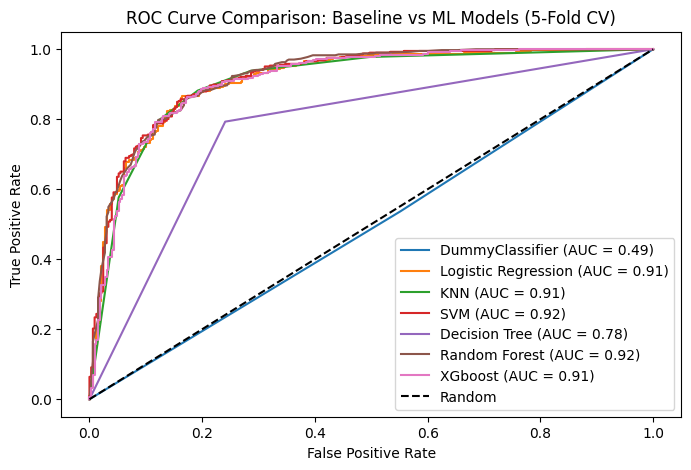

In [179]:
from sklearn.metrics import RocCurveDisplay
from sklearn.model_selection import cross_val_predict

plt.figure(figsize=(8, 5), facecolor="white")
ax = plt.gca()

for name, model in models:
        y_proba = cross_val_predict(model, X_train, y_train, cv=cv, method="predict_proba")[:, 1]
        RocCurveDisplay.from_predictions(y_train, y_proba, name=name, ax=ax)

plt.plot([0, 1], [0, 1], 'k--', label='Random')

plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve Comparison: Baseline vs ML Models (5-Fold CV)")
plt.legend(loc="lower right")
plt.grid(True, color="white", linewidth=0.7, alpha=0.7)
plt.show()

### ROC Curve (k-fold average)

The ROC curves below show the performance of different models using k-fold cross-validation.  
The **Area Under the Curve (AUC)** indicates the model’s ability to distinguish between classes.

- Random Forest: AUC ≈ 0.92  
- SVM: AUC ≈ 0.92  
- Logistic Regression: AUC ≈ 0.91  
- KNN: AUC ≈ 0.91  
- XGBoost: AUC ≈ 0.91  
- Decision Tree: AUC ≈ 0.78  

**Analysis:**  
- **Random Forest (0.92)** and **SVM (0.92)** achieved the best results.  
- **Logistic Regression, KNN, and XGBoost (0.91)** performed strongly and are very competitive with the top models.  
- **Decision Tree (0.78)** showed weaker performance compared to the others.  
- Overall, **ensemble models (Random Forest, XGBoost)** and **SVM** are the most reliable choices for this dataset.


### Confusion Matrix (k-fold average)
The confusion matrix summarizes the classification outcomes in terms of:
- True Positives (TP): correctly predicted positive cases
- False Positives (FP): negative cases incorrectly predicted as positive
- True Negatives (TN): correctly predicted negative cases
- False Negatives (FN): positive cases incorrectly predicted as negative

By aggregating results from all folds in k-fold cross-validation, we obtain the average confusion matrix, which provides a clearer view of each model’s overall classification performance.

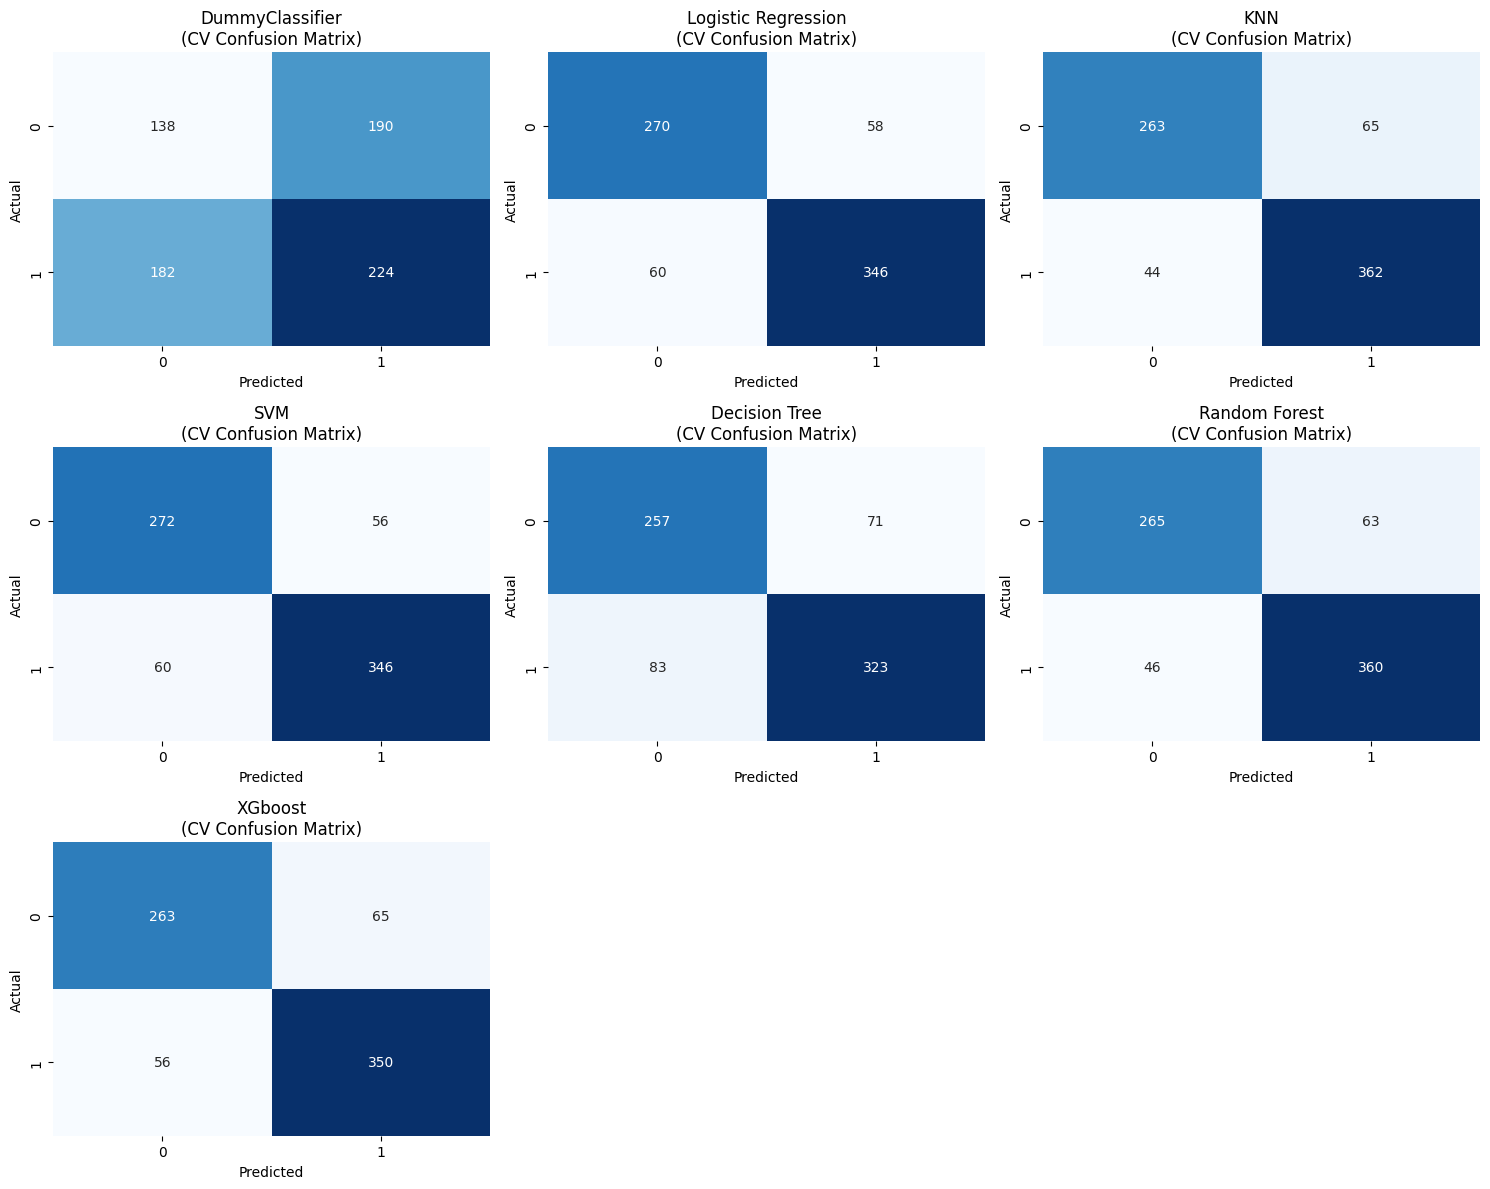

In [180]:
from sklearn.metrics import confusion_matrix

fig, axes = plt.subplots(3, 3, figsize=(15, 12))
axes = axes.ravel()

for (name, model), ax in zip(models, axes):
    y_pred = cross_val_predict(model, X_train, y_train, cv=5, method="predict")
    cm = confusion_matrix(y_train, y_pred)

    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False, ax=ax)
    ax.set_title(f"{name}\n(CV Confusion Matrix)")
    ax.set_xlabel("Predicted")
    ax.set_ylabel("Actual")

# delete subplot not ues
for j in range(len(models), len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

📊 The confusion matrix shows practical performance at the 0.5 decision threshold.

# Hyperparameter Tuning

## Model Selection for Tuning

We selected three models for hyperparameter tuning based on their performance in the previous evaluation:

1. SVM (AUC = 0.92)
2. Random Forest (AUC = 0.92)
3. KNN (AUC = 0.91)

Although KNN and XGBoost both have AUC ≈ 0.91, we chose KNN because it produced fewer False Negatives (FN).  
In Heart Disease prediction, minimizing FN is critical because misclassifying a patient as healthy could delay treatment.

**Rationale:**  
- Prioritize models with high discrimination (AUC)  
- Consider domain-specific impact (FN reduction)  
- Combine quantitative metrics with practical consequences for model selection

## Hyperparameter Tuning Approach

We use **GridSearchCV** to find the optimal hyperparameters for each selected model.  
- GridSearchCV evaluates all combinations of specified parameters.  
- Internal **cross-validation** ensures robust performance estimation and reduces overfitting risk.  
- Scoring metric: weighted F1-score (to balance precision and recall in imbalanced Heart Disease dataset).  

### Hyperparameter Tuning: SVM

In [181]:
from sklearn.metrics import make_scorer, precision_score, recall_score, f1_score

scoring = {
    "precision": make_scorer(precision_score, average="weighted", zero_division=0),
    "recall": make_scorer(recall_score, average="weighted", zero_division=0),
    "f1": make_scorer(f1_score, average="weighted", zero_division=0)
}

In [182]:
from sklearn.model_selection import GridSearchCV

param_grid_svc = {
    "classifier__C": [0.1, 1, 10],
    "classifier__kernel": ["linear", "rbf"],
    "classifier__gamma": ["scale", "auto", 0.01, 0.1, 1]
}

grid_svc = GridSearchCV(pipe_svc, param_grid_svc, cv=cv, scoring=scoring, refit="f1", n_jobs=-1)

In [183]:
grid_svc.fit(X_train, y_train)
print("SVM Best params:", grid_svc.best_params_)
print("SVM mean precision (CV):", grid_svc.cv_results_['mean_test_precision'][grid_svc.best_index_])
print("SVM mean recall (CV):", grid_svc.cv_results_['mean_test_recall'][grid_svc.best_index_])
print("SVM mean f1 (CV):", grid_svc.cv_results_['mean_test_f1'][grid_svc.best_index_])

SVM Best params: {'classifier__C': 1, 'classifier__gamma': 0.1, 'classifier__kernel': 'rbf'}
SVM mean precision (CV): 0.8515855304439176
SVM mean recall (CV): 0.8501910353182369
SVM mean f1 (CV): 0.8498884516486893


### Hyperparameter Tuning: Random Forest

In [184]:
param_grid_rf = {
    "classifier__n_estimators": [100, 200, 300],
    "classifier__max_depth": [None, 5, 10],
    "classifier__min_samples_split": [2, 5, 10],
    "classifier__min_samples_leaf": [1, 2, 4]
}

grid_rf = GridSearchCV(pipe_rf, param_grid_rf, cv=5, scoring=scoring, refit="f1", n_jobs=-1)

In [185]:
grid_rf.fit(X_train, y_train)

print("\nRF Best params:", grid_rf.best_params_)
print("RF mean precision (CV):", grid_rf.cv_results_['mean_test_precision'][grid_rf.best_index_])
print("RF mean recall (CV):", grid_rf.cv_results_['mean_test_recall'][grid_rf.best_index_])
print("RF mean f1 (CV):", grid_rf.cv_results_['mean_test_f1'][grid_rf.best_index_])


RF Best params: {'classifier__max_depth': 10, 'classifier__min_samples_leaf': 1, 'classifier__min_samples_split': 2, 'classifier__n_estimators': 200}
RF mean precision (CV): 0.8577706030977172
RF mean recall (CV): 0.8555120678408349
RF mean f1 (CV): 0.8546784007705621


### Hyperparameter Tuning: KNN

In [186]:
param_grid_knn = {
    "classifier__n_neighbors": [3, 5, 7, 9, 11],
    "classifier__weights": ["uniform", "distance"],
    "classifier__metric": ["euclidean", "manhattan", "minkowski"]
}

grid_knn = GridSearchCV(pipe_knn, param_grid_knn, cv=5, scoring=scoring, refit="f1", n_jobs=-1)

In [187]:
grid_knn.fit(X_train, y_train)

print("\nKNN Best params:", grid_knn.best_params_)
print("KNN mean precision (CV):", grid_knn.cv_results_['mean_test_precision'][grid_knn.best_index_])
print("KNN mean recall (CV):", grid_knn.cv_results_['mean_test_recall'][grid_knn.best_index_])
print("KNN mean f1 (CV):", grid_knn.cv_results_['mean_test_f1'][grid_knn.best_index_])


KNN Best params: {'classifier__metric': 'euclidean', 'classifier__n_neighbors': 9, 'classifier__weights': 'uniform'}
KNN mean precision (CV): 0.856664848957198
KNN mean recall (CV): 0.8555493430248813
KNN mean f1 (CV): 0.8548271444495976


### Hyperparameter Tuning Summary (k-fold average)

| Model           | Best Parameters           | Mean Precision | Mean Recall | Mean F1-score |
|-----------------|--------------------------|----------------|-------------|---------------|
| SVM             | `'classifier__C': 1, 'classifier__gamma': 0.1, 'classifier__kernel': 'rbf'`  | 0.85           | 0.85        | 0.85          |
| KNN             | `classifier__metric': 'euclidean', 'classifier__n_neighbors': 9, 'classifier__weights': 'uniform`  | 0.86           | 0.86        | 0.85          |
| Random Forest   | `classifier__max_depth': 10, 'classifier__min_samples_leaf': 1, 'classifier__min_samples_split': 2, 'classifier__n_estimators': 200`   | 0.86           | 0.86        | 0.85          |

**Notes:**  
- Metrics are averaged across k-fold cross-validation  
- Weighted F1-score used to balance precision and recall in imbalanced Heart Disease dataset

## Evaluation of Tuned Models (Hyperparameter Tuning)

### ROC Curve (k-fold average)

The ROC curves below compare the performance of the three tuned models.  
The **Area Under the Curve (AUC)** indicates how well each model distinguishes between positive and negative cases.

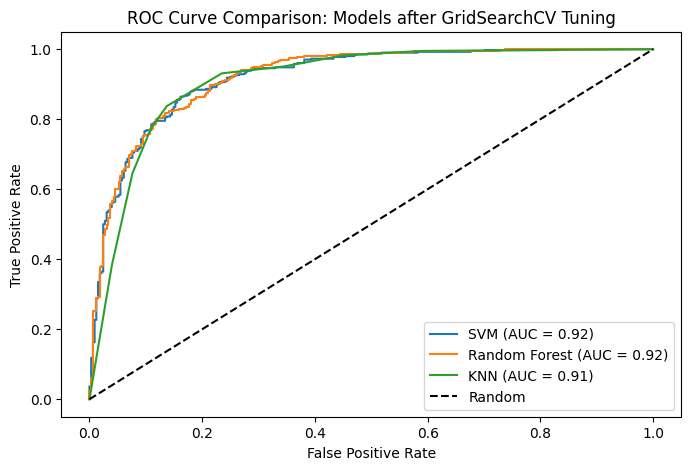

In [188]:
models_results = [
    ("SVM", grid_svc.best_estimator_),
    ("Random Forest", grid_rf.best_estimator_),
    ("KNN", grid_knn.best_estimator_)
]

plt.figure(figsize=(8, 5), facecolor="white")
ax = plt.gca()

for name, model in models_results:
        y_proba = cross_val_predict(model, X_train, y_train, cv=cv, method="predict_proba")[:, 1]
        RocCurveDisplay.from_predictions(y_train, y_proba, name=name, ax=ax)

plt.plot([0, 1], [0, 1], 'k--', label='Random')

plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve Comparison: Models after GridSearchCV Tuning")
plt.legend(loc="lower right")
plt.grid(True, color="white", linewidth=0.7, alpha=0.7)
plt.show()

- SVM: AUC ≈ 0.92  
- Random Forest: AUC ≈ 0.92  
- KNN: AUC ≈ 0.91  

**Observation:** All three models achieve high discrimination ability.

### Confusion Matrix (k-fold average)
The confusion matrices summarize the classification results for the three tuned models.

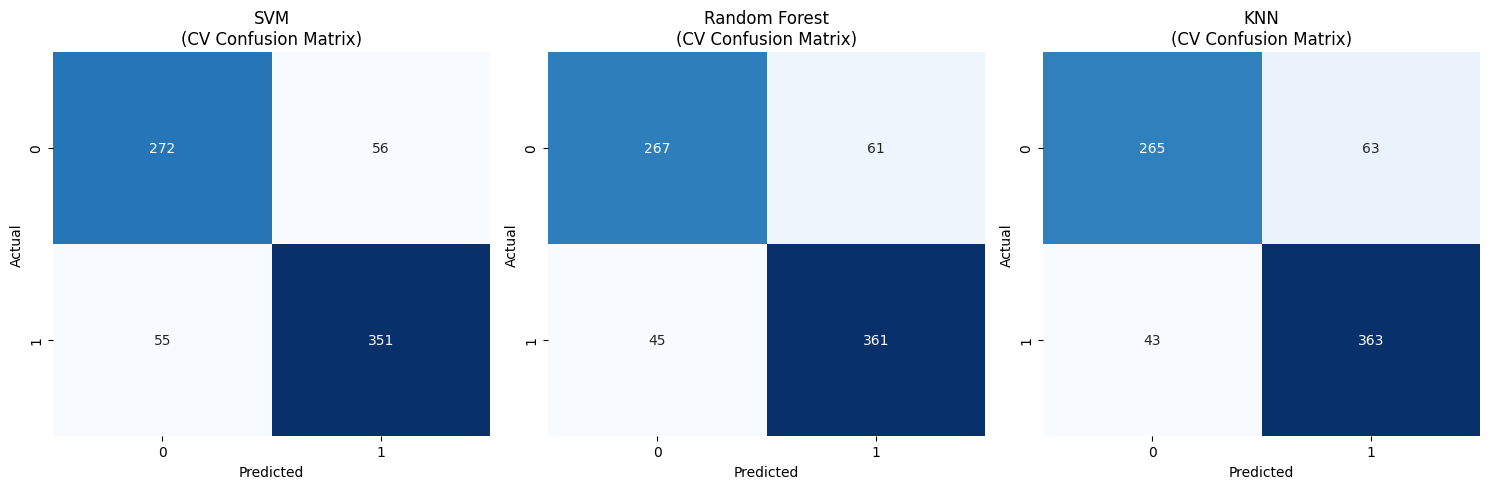

In [189]:
models = [
    ("SVM", grid_svc.best_estimator_),
    ("Random Forest", grid_rf.best_estimator_),
    ("KNN", grid_knn.best_estimator_)
]

fig, axes = plt.subplots(1, 3, figsize=(15, 5))
axes = axes.ravel()

for (name, model), ax in zip(models, axes):
    y_pred = cross_val_predict(model, X_train, y_train, cv=5)
    cm = confusion_matrix(y_train, y_pred)

    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False, ax=ax)
    ax.set_title(f"{name}\n(CV Confusion Matrix)")
    ax.set_xlabel("Predicted")
    ax.set_ylabel("Actual")

plt.tight_layout()
plt.show()

- SVM: FN = 55  
- Random Forest: FN = 45  
- KNN: FN = 43 (**lowest among 3 models**)  

**Key Observation:** Minimizing False Negatives (FN) is crucial for Heart Disease prediction, since misclassifying a patient as healthy could delay treatment.

## ✅ Final Model Selection

- Although SVM and Random Forest have slightly higher AUC (0.92) than KNN (0.91), **KNN produces the fewest False Negatives**.  
- Therefore, **Tuned KNN** is selected as the **final model** for Heart Disease prediction due to the combination of high overall metrics and minimized FN.

# KNN Model Evaluation: Baseline vs Tuned

We evaluate **Baseline KNN** and **Tuned KNN** to justify the selection of the final model.  

- **Goal:** Identify improvements in classification performance while minimizing False Negatives (FN), which is critical for Heart Disease prediction.  
- **Metrics Compared:** Weighted Precision, Recall, F1-score  
- **Additional Evaluation:** Confusion Matrix to visualize TP, FP, TN, FN


## 1️⃣ Confusion Matrix Comparison

The confusion matrices compare **Baseline KNN** and **Tuned KNN**:  

- **Observation:** Tuned KNN reduces **False Negatives (FN)** by 1 case, improving patient safety.  
- After hyperparameter tuning, recall improved slightly, reducing 1 false negative. This shows KNN was already performing well as baseline, but tuning ensured optimal parameters.

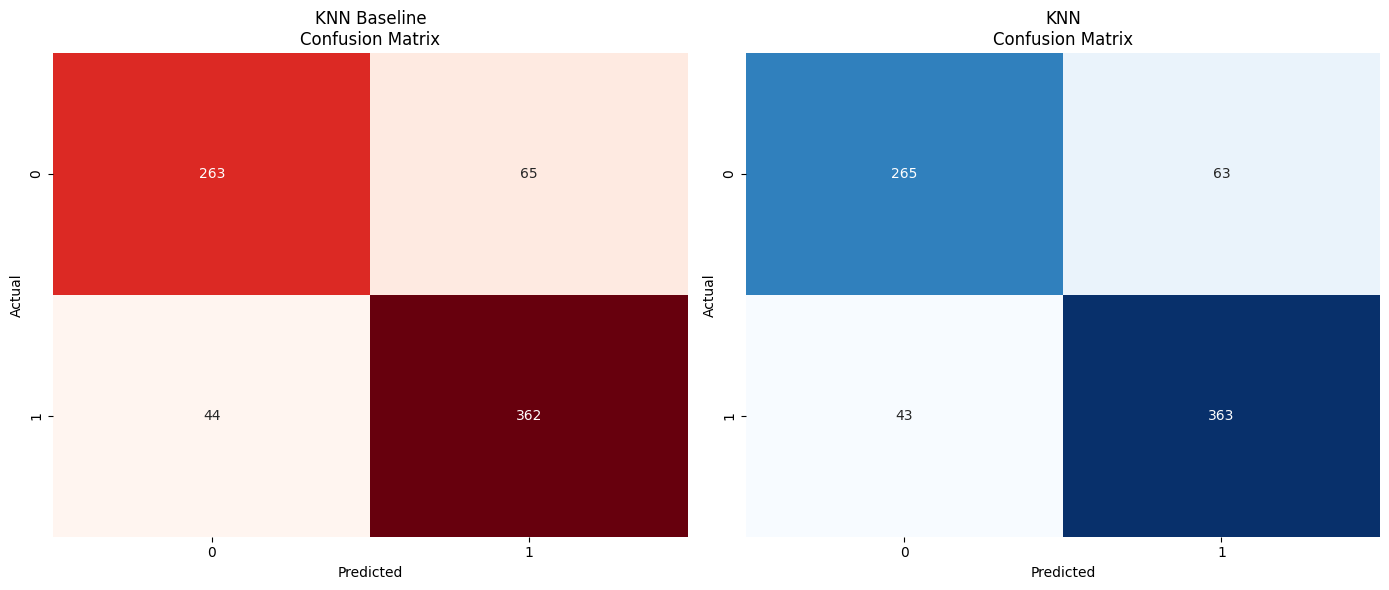

In [190]:
# knn tuned (best estimator จาก GridSearchCV)
knn_tuned = grid_knn.best_estimator_

# Confusion matrix
y_pred_baseline = cross_val_predict(pipe_knn, X_train, y_train, cv=5)
y_pred_tuned = cross_val_predict(knn_tuned, X_train, y_train, cv=5)

cm_baseline = confusion_matrix(y_train, y_pred_baseline)
cm_tuned = confusion_matrix(y_train, y_pred_tuned)

# Metric
metrics = ['Precision', 'Recall', 'F1-score']
baseline_scores = [
    precision_score(y_train, y_pred_baseline),
    recall_score(y_train, y_pred_baseline),
    f1_score(y_train, y_pred_baseline)
]

tuned_scores = [
    precision_score(y_train, y_pred_tuned),
    recall_score(y_train, y_pred_tuned),
    f1_score(y_train, y_pred_tuned)
]

# Confusion matrix side by side
fig, axes = plt.subplots(1, 2, figsize=(14,6))

sns.heatmap(cm_baseline, annot=True, fmt="d", cmap="Reds", cbar=False, ax=axes[0])
axes[0].set_title("KNN Baseline\nConfusion Matrix")
axes[0].set_xlabel("Predicted")
axes[0].set_ylabel("Actual")

sns.heatmap(cm_tuned, annot=True, fmt="d", cmap="Blues", cbar=False, ax=axes[1])
axes[1].set_title("KNN\nConfusion Matrix")
axes[1].set_xlabel("Predicted")
axes[1].set_ylabel("Actual")

plt.tight_layout()
plt.show()

## 2️⃣ Performance Metrics: Bar Chart

The bar chart below compares **Precision, Recall, and F1-score** (weighted) for Baseline vs Tuned KNN.

- **Observation:** All metrics improve after tuning, indicating better overall performance in predicting both classes.


In [191]:
df_bar = pd.DataFrame({
    'Metric': metrics*2,
    'Score': baseline_scores + tuned_scores,
    'Model': ['Baseline']*3 + ['Tuned']*3
})

fig_bar = px.bar(df_bar, x="Metric", y="Score", color="Model", barmode="group",
                 text="Score", title="KNN Metric Comparison: Baseline vs Tuned")
fig_bar.update_traces(texttemplate='%{text:.3f}', textposition='outside')
fig_bar.update_layout(yaxis=dict(range=[0,1]))
fig_bar.show()

## 3️⃣ Conclusion

- **Tuned KNN** outperforms Baseline KNN in **Precision, Recall, and F1-score**.  
- **False Negatives (FN)** are reduced, lowering the risk of misclassifying patients as healthy.  
- **Final Decision:** Tuned KNN is selected as the **final model** for Heart Disease prediction due to its combination of high metrics and minimized FN.


# Final Model (KNN) Evaluation on Test Set

After selecting the **Tuned KNN** as the final model, we evaluate its performance on the **test set**, which contains unseen data.

## Predictions
- Use the final KNN model to predict labels for `X_test`.

In [192]:
final_knn = grid_knn.best_estimator_

# Train final model
final_knn.fit(X_train, y_train)

# Predict on test set
y_test_pred = final_knn.predict(X_test)

## Metrics Bar Chart

In [193]:
metrics = ['Precision', 'Recall', 'F1-score']
scores = [
    precision_score(y_test, y_test_pred),
    recall_score(y_test, y_test_pred),
    f1_score(y_test, y_test_pred)
]

df_bar = pd.DataFrame({
    'Metric': metrics,
    'Score': scores
})

fig_bar = px.bar(
    df_bar,
    x="Metric",
    y="Score",
    text="Score",
    color="Metric", 
    title="Final KNN Metrics on Test Set (Class 1: Heart Disease)" 
)

fig_bar.update_traces(texttemplate='%{text:.3f}', textposition='outside')
fig_bar.update_layout(yaxis=dict(range=[0,1]), showlegend=False)  
fig_bar.show()

**The bar chart shows Precision, Recall, and F1-score on the test set.**
- Recall = 0.853, indicating the model correctly identifies ~85% of actual Heart Disease cases.  
- About 15% of patients are still missed (False Negatives).  
- Recall on the test set is close to cross-validation (~0.85), showing the model generalizes well.

## Confusion Matrix

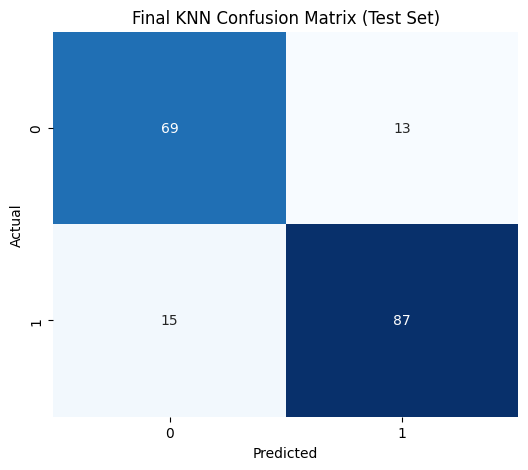

In [194]:
# Confusion matrix
cm_test = confusion_matrix(y_test, y_test_pred)

plt.figure(figsize=(6,5))
sns.heatmap(cm_test, annot=True, fmt="d", cmap="Blues", cbar=False)
plt.title("Final KNN Confusion Matrix (Test Set)")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

The confusion matrix shows that the model maintains balanced performance on unseen data.  
False Negatives (FN) remain low, which is particularly important for Heart Disease prediction.

## ROC Curve

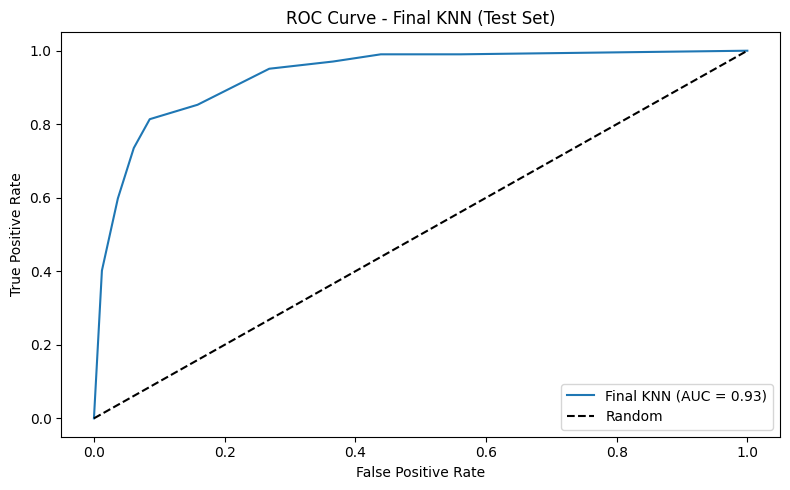

In [195]:
plt.figure(figsize=(8, 5), facecolor="white")
ax = plt.gca()
# ax.set_facecolor("lightgray")

# ใช้ final_knn แทน models
y_proba = final_knn.predict_proba(X_test)[:, 1]  # probability ของ class positive
RocCurveDisplay.from_predictions(y_test, y_proba, name="Final KNN", ax=ax)

# เส้น random baseline
plt.plot([0, 1], [0, 1], 'k--', label='Random')

plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve - Final KNN (Test Set)")
plt.legend(loc="lower right")
plt.grid(True, color="white", linewidth=0.7, alpha=0.7)

plt.tight_layout()
plt.show()

After hyperparameter tuning, the final KNN model achieved slightly higher metrics on the test set compared to cross-validation results. This indicates that the model generalizes well to unseen data, though slight differences may occur due to random variation in the test set or data distribution.

# **Check overfitting / generalization**

In [196]:
# --- Training metrics ---
y_train_pred = final_knn.predict(X_train)
train_precision = precision_score(y_train, y_train_pred, average='binary')
train_recall = recall_score(y_train, y_train_pred, average='binary')
train_f1 = f1_score(y_train, y_train_pred, average='binary')

# --- Test metrics ---
y_test_pred = final_knn.predict(X_test)
test_precision = precision_score(y_test, y_test_pred, average='binary')
test_recall = recall_score(y_test, y_test_pred, average='binary')
test_f1 = f1_score(y_test, y_test_pred, average='binary')

# --- Print raw metrics ---
print("Training metrics: Precision={:.3f}, Recall={:.3f}, F1={:.3f}".format(train_precision, train_recall, train_f1))
print("Test metrics:     Precision={:.3f}, Recall={:.3f}, F1={:.3f}".format(test_precision, test_recall, test_f1))

# --- Check overfitting/generalization ---
threshold = 0.05  # กำหนด gap >5% ถือว่ามาก
metrics = ['Precision', 'Recall', 'F1-score']
train_scores = [train_precision, train_recall, train_f1]
test_scores = [test_precision, test_recall, test_f1]

for metric, tr, te in zip(metrics, train_scores, test_scores):
    gap = tr - te
    if gap > threshold:
        status = "Overfitting detected"
    elif gap < -threshold:
        status = "Underfitting detected"
    else:
        status = "Generalizes well"
    print(f"{metric}: Train={tr:.3f}, Test={te:.3f} --> {status}")


Training metrics: Precision=0.877, Recall=0.914, F1=0.895
Test metrics:     Precision=0.870, Recall=0.853, F1=0.861
Precision: Train=0.877, Test=0.870 --> Generalizes well
Recall: Train=0.914, Test=0.853 --> Overfitting detected
F1-score: Train=0.895, Test=0.861 --> Generalizes well


## Train-Test Score

| Metric      | Train | Test | Observation |
|------------|-------|------|-------------|
| Precision  | 0.877 | 0.870 | Small gap (0.007) → **generalizes well** |
| Recall     | 0.914 | 0.853 | Gap ~0.061 → **slight overfitting detected** |
| F1-score   | 0.895 | 0.861 | Gap 0.034 → **generalizes well** |

**Analysis:**

- **Precision:** The model predicts positive cases accurately on unseen data, showing strong generalization.  
- **Recall:** Slightly lower on the test set, indicating the model misses some positives in unseen data (minor overfitting).  
- **F1-score:** Combines precision and recall; the small gap suggests overall balanced performance.

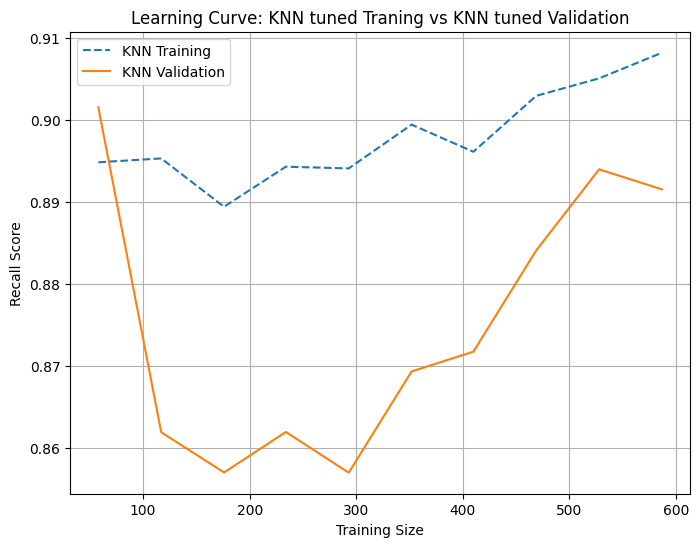

In [197]:
from sklearn.model_selection import learning_curve

plt.figure(figsize=(8,6))

train_sizes, train_scores, test_scores = learning_curve(
    estimator=final_knn,
    X=X_train,
    y=y_train,
    cv=5,
    scoring='recall',  # optimize recall
    train_sizes=np.linspace(0.1, 1.0, 10),
    n_jobs=-1
)
train_mean = np.mean(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)
    
plt.plot(train_sizes, train_mean, '--', label=f'{name} Training')
plt.plot(train_sizes, test_mean, '-', label=f'{name} Validation')

plt.xlabel('Training Size')
plt.ylabel('Recall Score')
plt.title('Learning Curve: KNN tuned Traning vs KNN tuned Validation')
plt.legend()
plt.grid(True)
plt.show()

## Learning Curve Analysis

- **Training Recall (blue dashed line):** Consistently high (~0.89–0.91), indicating the model learns well from training data.  
- **Validation Recall (orange line):** Starts lower (~0.86) but improves as training size increases, approaching training recall.  
- **Gap between training and validation:** Narrows with more data, indicating reduced overfitting and better generalization. 

## ✅ Conclusion

- The tuned KNN model **generalizes well overall**, with only minor overfitting in Recall.  
- Increasing training data or tuning hyperparameters (e.g., `K`) can help further reduce overfitting.  
- The model is **ready for deployment** while monitoring Recall and F1-score for sensitive detection of heart disease.

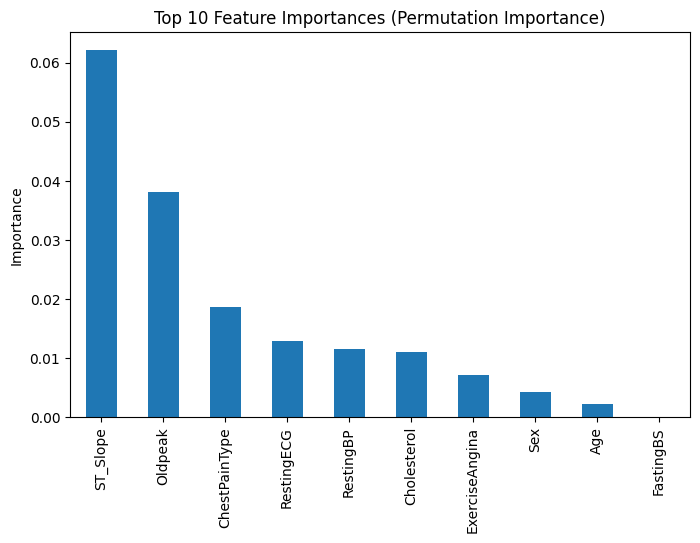

In [198]:
from sklearn.inspection import permutation_importance

model = grid_knn.best_estimator_

# permutation importance (ใช้ scoring recall สำหรับ Heart Disease)
result = permutation_importance(
    model, X_train, y_train,
    n_repeats=10,
    random_state=42,
    scoring='recall'
)

perm_importances = pd.Series(result.importances_mean, index=X_train.columns)
perm_importances = perm_importances.sort_values(ascending=False)

# Plot top 10 features
plt.figure(figsize=(8,5))
perm_importances.head(10).plot(kind='bar')
plt.title('Top 10 Feature Importances (Permutation Importance)')
plt.ylabel('Importance')
plt.show()

# Feature importance
MaxHR shows strong separation in EDA and a negative correlation with the target. However, permutation importance for the KNN model ranks ST_slope as the most important feature. This difference occurs because KNN relies on multivariate distances and the chosen metric (Recall), highlighting that feature importance depends on both the model and the evaluation metric.

# Saving the Final KNN Model
After training and evaluating the final KNN model for Heart Disease prediction, we save the model for future use or deployment. This demonstrates **model persistence** in the workflow.

In [199]:
from joblib import dump, load

# Save the final KNN model to a file
# This file can be loaded later for prediction on new data

dump(final_knn, "knn_heart_disease.joblib")

['knn_heart_disease.joblib']